In [27]:
import numpy as np
import pandas as pd

n = 10000  # table size
table = np.outer(np.arange(1, n+1), np.arange(1, n+1))
df_table = pd.DataFrame(table, index=np.arange(1, n+1), columns=np.arange(1, n+1))


In [28]:
df_table.head()

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
1,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
2,2,4,6,8,10,12,14,16,18,20,...,19982,19984,19986,19988,19990,19992,19994,19996,19998,20000
3,3,6,9,12,15,18,21,24,27,30,...,29973,29976,29979,29982,29985,29988,29991,29994,29997,30000
4,4,8,12,16,20,24,28,32,36,40,...,39964,39968,39972,39976,39980,39984,39988,39992,39996,40000
5,5,10,15,20,25,30,35,40,45,50,...,49955,49960,49965,49970,49975,49980,49985,49990,49995,50000


In [29]:
from scipy.stats import entropy

def row_entropy(row):
    values, counts = np.unique(row, return_counts=True)
    probs = counts / counts.sum()
    return entropy(probs, base=2)  # Shannon entropy in bits

row_entropies = df_table.apply(row_entropy, axis=1)


In [30]:
X = np.hstack([
    df_table.values,
    row_entropies.values.reshape(-1, 1)
])


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


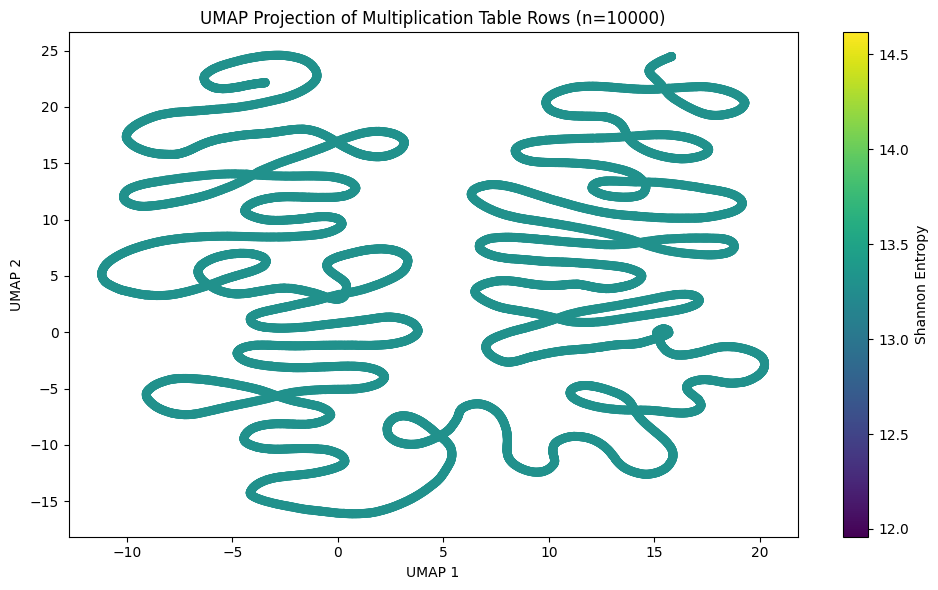

In [31]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=row_entropies, cmap='viridis', s=30)
plt.colorbar(label='Shannon Entropy')
plt.title(f'UMAP Projection of Multiplication Table Rows (n={n})')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()


In [32]:
from sympy import factorint

def num_prime_divisors(n):
    return len(factorint(n))  # distinct prime factors only

row_indices = np.arange(1, n+1)
prime_div_counts = np.array([num_prime_divisors(i) for i in row_indices])


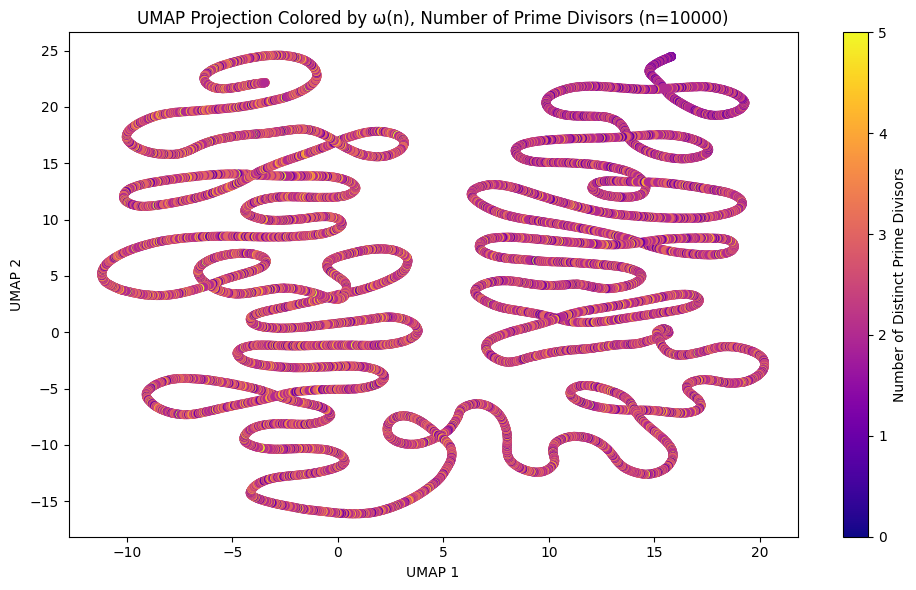

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=prime_div_counts, cmap='plasma', s=30)
plt.colorbar(label='Number of Distinct Prime Divisors')
plt.title(f'UMAP Projection Colored by ω(n), Number of Prime Divisors (n={n})')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()


In [34]:
import hdbscan

# Cluster UMAP coordinates
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
hdb_labels = clusterer.fit_predict(X_umap)

# Optional: membership strength for visualization
membership_strength = clusterer.probabilities_


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


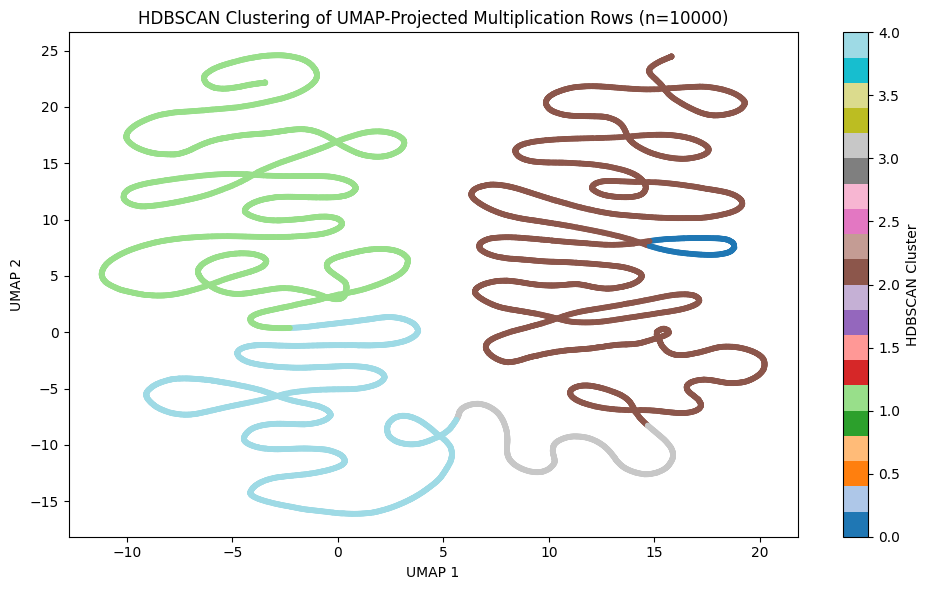

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=hdb_labels, cmap='tab20', s=10)
plt.colorbar(label='HDBSCAN Cluster')
plt.title('HDBSCAN Clustering of UMAP-Projected Multiplication Rows (n=10000)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()


In [36]:
row_indices = np.arange(1, n+1)         # these are your "integers"
hdb_labels                              # these are your cluster labels


array([2, 2, 2, ..., 1, 1, 1])

In [37]:
df_clusters = pd.DataFrame({
    'Integer': row_indices,
    'Cluster': hdb_labels,
    'Entropy': row_entropies,
    'PrimeDivisors': prime_div_counts
})


In [39]:
cluster_summary = df_clusters.groupby('Cluster').agg({
    'Integer': ['min', 'max', 'count'],
    'Entropy': ['mean', 'std'],
    'PrimeDivisors': ['mean', 'std']
}).sort_values(('Integer', 'min'))

# Pretty up the column names
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.reset_index(inplace=True)

cluster_summary


,Cluster,Integer_min,Integer_max,Integer_count,Entropy_mean,Entropy_std,PrimeDivisors_mean,PrimeDivisors_std
0,2,1,4165,3980,13.287712,0.0,2.322864,0.802127
1,0,1872,2056,185,13.287712,0.0,2.362162,0.803305
2,3,4166,4773,608,13.287712,0.0,2.460526,0.828898
3,4,4774,6884,2111,13.287712,0.0,2.486026,0.848008
4,1,6885,10000,3116,13.287712,0.0,2.526958,0.860538


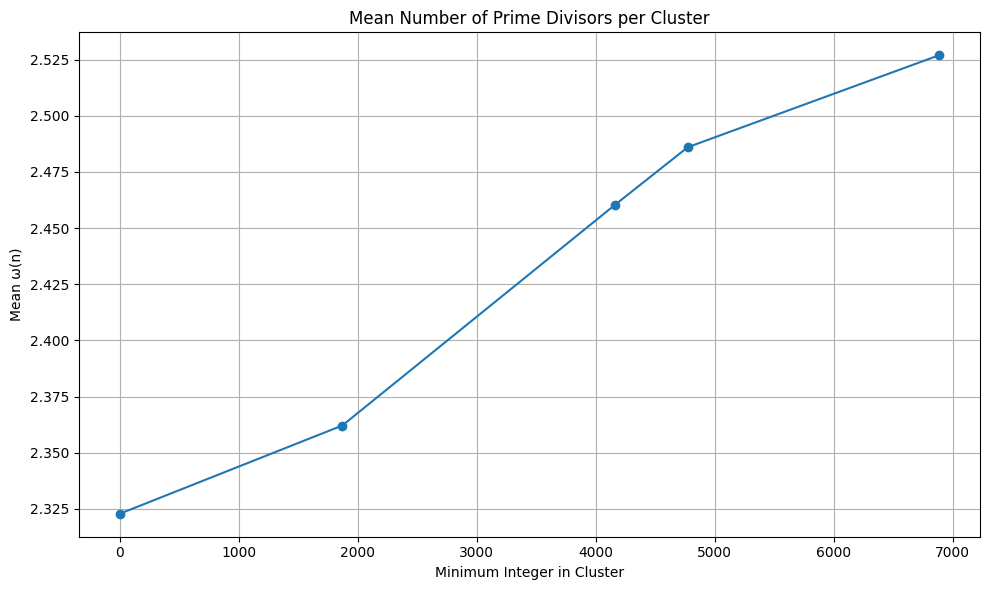

In [40]:
plt.figure(figsize=(10,6))
plt.plot(cluster_summary['Integer_min'], cluster_summary['PrimeDivisors_mean'], marker='o')
plt.title('Mean Number of Prime Divisors per Cluster')
plt.xlabel('Minimum Integer in Cluster')
plt.ylabel('Mean ω(n)')
plt.grid(True)
plt.tight_layout()
plt.show()


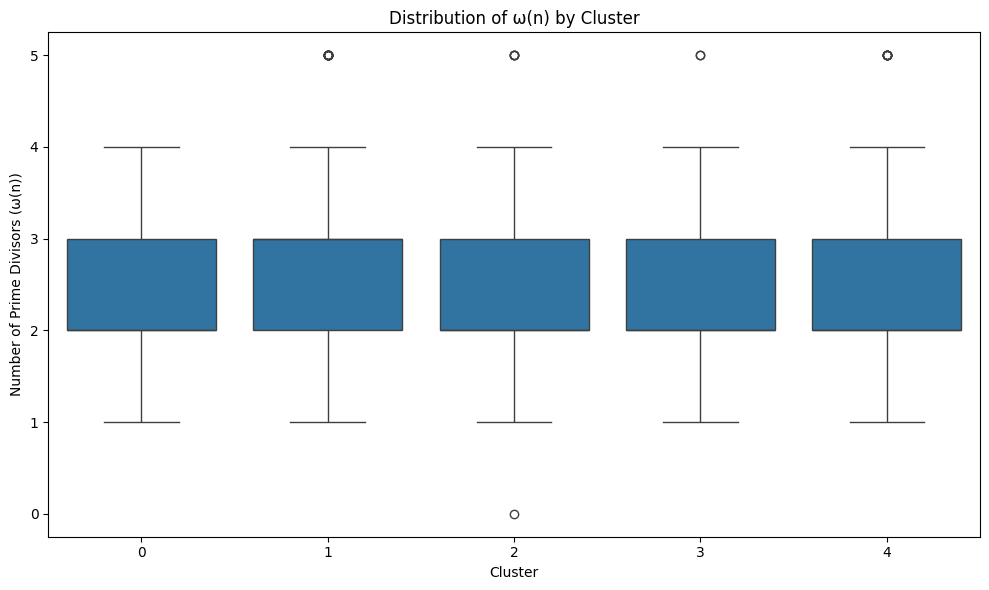

In [43]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(data=df_clusters, x='Cluster', y='PrimeDivisors')
plt.title('Distribution of ω(n) by Cluster')
plt.ylabel('Number of Prime Divisors (ω(n))')
plt.tight_layout()
plt.show()


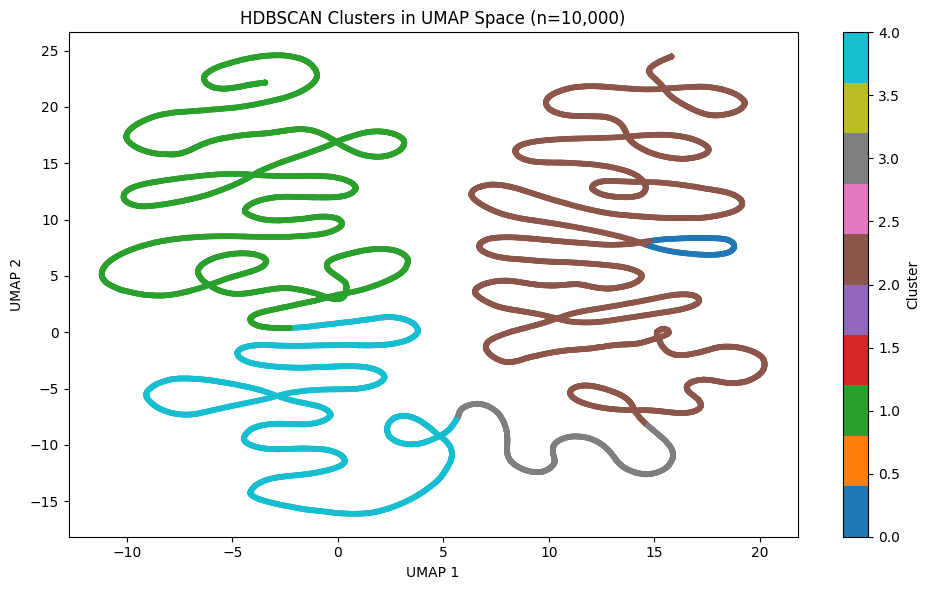

In [44]:
plt.figure(figsize=(10,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=hdb_labels, cmap='tab10', s=10)
plt.title('HDBSCAN Clusters in UMAP Space (n=10,000)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


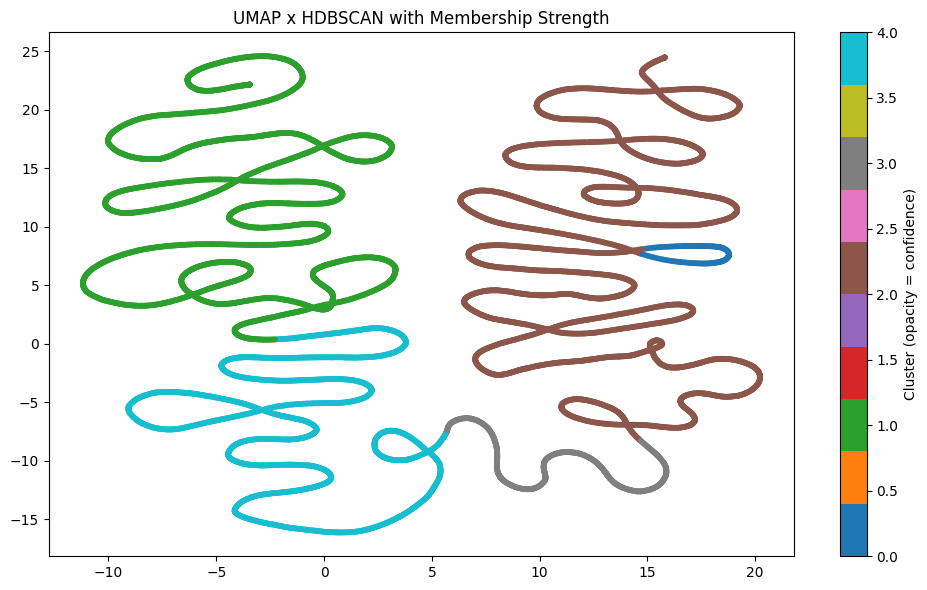

In [45]:
plt.figure(figsize=(10,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=hdb_labels, cmap='tab10', s=10, alpha=membership_strength)
plt.colorbar(label='Cluster (opacity = confidence)')
plt.title('UMAP x HDBSCAN with Membership Strength')
plt.tight_layout()
plt.show()


In [46]:
cluster_names = {
    0: "Prime-Sparse Base",
    1: "Transitional Wedge",
    2: "Composite Crest",
    3: "Multiplicative Mesh",
    4: "Entropy Plateau"
}

df_clusters['ClusterName'] = df_clusters['Cluster'].map(cluster_names)


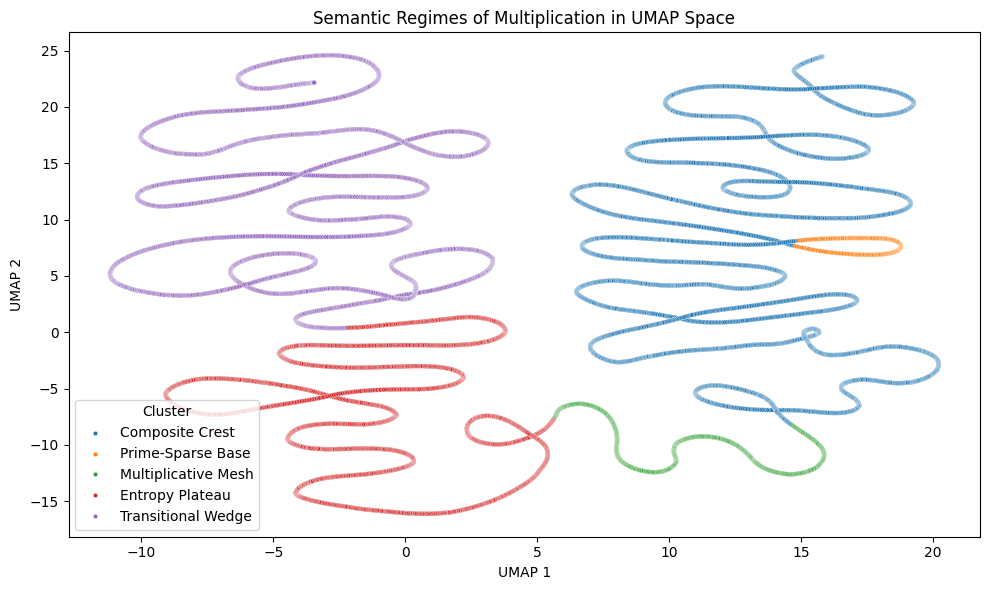

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=df_clusters['ClusterName'], palette='tab10', s=10)
plt.title("Semantic Regimes of Multiplication in UMAP Space")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [48]:
df_export = pd.DataFrame({
    'Integer': np.arange(1, n+1),
    'Entropy': row_entropies,
    'PrimeDivisors': prime_div_counts,
    'Cluster': hdb_labels,
    'ClusterName': df_clusters['ClusterName'].values,
    'UMAP1': X_umap[:, 0],
    'UMAP2': X_umap[:, 1]
})


In [49]:
df_export.to_csv("multiplication_umap_clusters.csv", index=False)
